In [1]:
import numpy as np
import sys
# sys.path.pop(2)
sys.path.insert(1,'/home/zhanibek/.local/lib/python2.7/site-packages/cv2')
import cv2 
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from tqdm import tqdm_notebook

In [2]:
cv2.__version__

'4.2.0'

### Functions

In [3]:
def showMarker(im):
    plt.imshow(im, interpolation='nearest', cmap='gray')

def read_image(fname):
    im = cv2.imread(fname)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

### Constants

In [4]:
base_dir = '../data/pose_estimation'

In [5]:
sqLength = 0.03677
mrkLegnth = 0.02959

In [6]:
'''
image 1: g_true = [[],
                   [],
                   [],
                   [0,0,0,1]]  # [R p]
                   
                   Euler angles, quaternion. Scipy -- how to compute Rotation matrices

'''

'\nimage 1: g_true = [[],\n                   [],\n                   [],\n                   [0,0,0,1]]  # [R p]\n                   \n                   Euler angles, quaternion. Scipy -- how to compute Rotation matrices\n\n'

In [30]:
vid = cv2.VideoCapture(0)
vid.set(cv2.CAP_PROP_FRAME_HEIGHT,1080)
vid.set(cv2.CAP_PROP_FRAME_WIDTH,1920)
vid.set(cv2.CAP_PROP_FPS, 60)

In [31]:
help(vid.set)

Help on built-in function set:

set(...)
    set(propId, value) -> retval
    .   @brief Sets a property in the VideoCapture.
    .   
    .       @param propId Property identifier from cv::VideoCaptureProperties (eg. cv::CAP_PROP_POS_MSEC, cv::CAP_PROP_POS_FRAMES, ...)
    .       or one from @ref videoio_flags_others
    .       @param value Value of the property.
    .       @return `true` if the property is supported by backend used by the VideoCapture instance.
    .       @note Even if it returns `true` this doesn't ensure that the property
    .       value has been accepted by the capture device. See note in VideoCapture::get()



In [32]:
cv2.CAP_PROP_FRAME_HEIGHT

4L

In [33]:
cv2.CAP_PROP_FRAME_WIDTH

3L

In [34]:
cv2.CAP_PROP_FPS

5L

In [35]:
vid.get(cv2.CAP_PROP_FPS)

30.0

In [28]:
cv2.CAP_PROP_

Help on long object:

class long(object)
 |  long(x=0) -> long
 |  long(x, base=10) -> long
 |  
 |  Convert a number or string to a long integer, or return 0L if no arguments
 |  are given.  If x is floating point, the conversion truncates towards zero.
 |  
 |  If x is not a number or if base is given, then x must be a string or
 |  Unicode object representing an integer literal in the given base.  The
 |  literal can be preceded by '+' or '-' and be surrounded by whitespace.
 |  The base defaults to 10.  Valid bases are 0 and 2-36.  Base 0 means to
 |  interpret the base from the string as an integer literal.
 |  >>> int('0b100', base=0)
 |  4L
 |  
 |  Methods defined here:
 |  
 |  __abs__(...)
 |      x.__abs__() <==> abs(x)
 |  
 |  __add__(...)
 |      x.__add__(y) <==> x+y
 |  
 |  __and__(...)
 |      x.__and__(y) <==> x&y
 |  
 |  __cmp__(...)
 |      x.__cmp__(y) <==> cmp(x,y)
 |  
 |  __coerce__(...)
 |      x.__coerce__(y) <==> coerce(x, y)
 |  
 |  __div__(...)
 |      x

In [ ]:
# 1920x1080

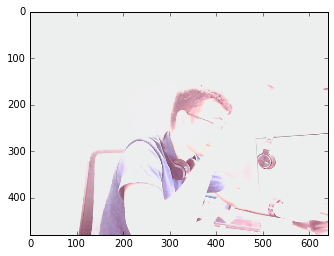

In [36]:
res, im = vid.read()
im0 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im0)
vid.release()

In [37]:
im0.shape

(480, 640, 3)

In [393]:
im_partial = read_image(os.path.join(base_dir, 'charuco_pose_est', 'im0_partial_view.png'))
im_full = read_image(os.path.join(base_dir, 'charuco_pose_est', 'im0_full_view.png'))
im_cat = read_image(os.path.join(base_dir, 'charuco_pose_est', 'cat.png'))

In [394]:
# cv2.imwrite(os.path.join(base_dir, 'charuco_pose_est', 'im0_partial_view.png'), im0)

### Charuco Board for Calibration

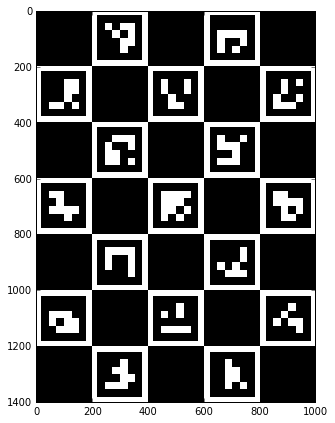

In [57]:

aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
calib_board = aruco.CharucoBoard_create(5, 7, sqLength, mrkLegnth, aruco_dict)
imboard = calib_board.draw((1000, 1400))

# cv2.imwrite(os.path.join(base_dir, "charuco_calibration.tiff"), imboard)

fig = plt.figure(figsize=(5,7))
showMarker(imboard)
plt.show()


### Charuco Board for Detection 1

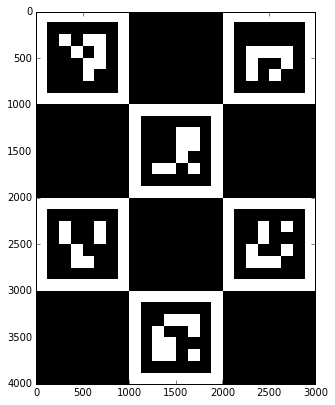

In [360]:
sqLen = 0.0644
mrklen = 0.04865 
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
board1 = aruco.CharucoBoard_create(3, 4, sqLen, mrklen, aruco_dict)
imboard1 = board1.draw((3000, 4000))

# cv2.imwrite(os.path.join(base_dir, "charuco_detection_1.tiff"), imboard)

fig = plt.figure(figsize=(5,7))
showMarker(imboard1)
plt.show()


### Charuco Board for Detection 2

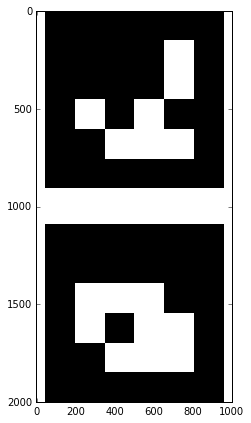

In [296]:
sep2 = 0.02274
mrklen2 = 0.11376 
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
board2 = aruco.GridBoard_create(1, 2, mrklen2, sep2, aruco_dict, 11)
# board2.ids = np.array([[11],[15]])
imboard = board2.draw((1000, 2000))

cv2.imwrite(os.path.join(base_dir, "charuco_detection_2.tiff"), imboard)

fig = plt.figure(figsize=(5,7))
showMarker(imboard)
plt.show()


In [294]:
im0.shape

(480, 640, 3)

In [291]:
board2.

array([[11],
       [12]], dtype=int32)

In [ ]:
board2 = aruco.GridBoard_create

In [ ]:
board1 = aruco.Board_create

### Playing with Dictionaries

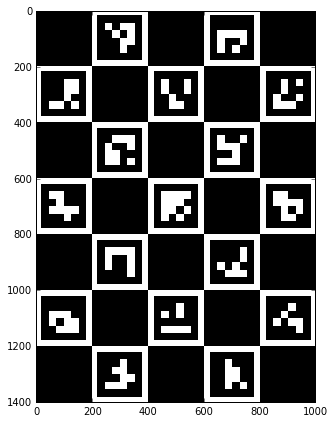

In [23]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
aruco_dict1 = aruco.custom_dictionary(16, 32, 0)

board = aruco.CharucoBoard_create(5, 7, 1, .8, aruco_dict)
imboard = board.draw((1000, 1400))

plt.figure(figsize=(5,7))
# plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
showMarker(imboard)
plt.show()

# Calibrate

In [68]:
datadir = "/home/zhanibek/catkin_ws/src/smart_tray/data/pose_estimation/calibration/logitech_t1/images/"
images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".png") ])
order = np.argsort([int(p.split('/')[-1].split("_")[1].split("_")[0]) for p in images])
images = images[order]
len(images)

49

In [69]:
images

array(['/home/zhanibek/catkin_ws/src/smart_tray/data/pose_estimation/calibration/logitech_t1/images/calib_0_10062020173227_878464.png',
       '/home/zhanibek/catkin_ws/src/smart_tray/data/pose_estimation/calibration/logitech_t1/images/calib_1_10062020173228_379042.png',
       '/home/zhanibek/catkin_ws/src/smart_tray/data/pose_estimation/calibration/logitech_t1/images/calib_2_10062020173228_879049.png',
       '/home/zhanibek/catkin_ws/src/smart_tray/data/pose_estimation/calibration/logitech_t1/images/calib_3_10062020173229_379010.png',
       '/home/zhanibek/catkin_ws/src/smart_tray/data/pose_estimation/calibration/logitech_t1/images/calib_4_10062020172536_634931.png',
       '/home/zhanibek/catkin_ws/src/smart_tray/data/pose_estimation/calibration/logitech_t1/images/calib_4_10062020173229_879060.png',
       '/home/zhanibek/catkin_ws/src/smart_tray/data/pose_estimation/calibration/logitech_t1/images/calib_5_10062020172537_134910.png',
       '/home/zhanibek/catkin_ws/src/smart_tray/

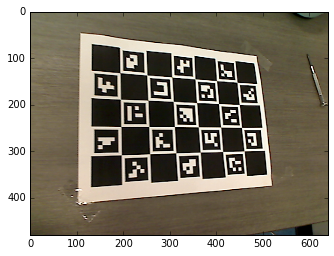

In [70]:
im = read_image(images[20])
plt.figure()
plt.imshow(im)
#ax.axis('off')
plt.show()

In [71]:
class Calibrate_Camera:
    """Calibrate an individual camera"""
    def __init__(self, board):
#         self.dictionary = aruco.Dictionary_get(aruco.DICT_6X6_250)
#         self.row = 7  # horizontal
#         self.col = 5  # vertical
#         self.sqr = 1  # solid black squares
#         self.mrk = 0.8 # markers, must be smaller than squares
#         self.board = aruco.CharucoBoard_create(
#             self.col,self.row,
#             self.sqr,
#             self.mrk,
#             self.dictionary)
        self.board = board
        self.dictionary = self.board.dictionary

    def calculateReprojectionError(self, imgpoints, objpoints, rvecs, tvecs, mtx, dist):
        """
        imgpts: features found in image, (num_imgs, 2)
        objpts: calibration known features in 3d, (num_imgs, 3)
        """
        imgpoints = [c.reshape(-1,2) for c in imgpoints]
        mean_error = 0
        for i in range(len(objpoints)):
            imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
            imgpoints2 = imgpoints2.reshape(-1,2)

            # if not all markers were found, then the norm below will fail
            if len(imgpoints[i]) != len(imgpoints2):
                continue
                
            error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
            mean_error += error

        total_error = mean_error/len(objpoints)
        return total_error

    def calibrate(self, images):
        corners_all = []  # corners in all images
        ids_all = []  # ids found in all images
        image_size = None

#         images = glob.glob('./calib_images/*.jpg')

        for imname in tqdm_notebook(images):

            img = cv2.imread(imname)

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
              
            corners, ids, rejectedImgPts = aruco.detectMarkers(gray, self.dictionary)
            
            # if ids were found, then
            if ids is not None and len(ids) > 0:
                ret, ch_corners, ch_ids = aruco.interpolateCornersCharuco(
                    corners, ids, gray, self.board)

                corners_all.append(ch_corners)
                ids_all.append(ch_ids)

        image_size = gray.shape[::-1]

        # Make sure at least one image was found
        if len(images) < 1:
            #Calibration failed because there were no images, warn the user
            print("Calibration was unsuccessful. No images of charucoboards were found. Add images of charucoboards and use or alter the naming conventions used in this file.")
            # Exit for failure
            exit()

        rms, cameraMatrix, distCoeffs, rvecs, tvecs = aruco.calibrateCameraCharuco(
            corners_all, ids_all, self.board, image_size, None, None)

        h, w = self.board.chessboardCorners.shape
        objpts = [self.board.chessboardCorners.reshape((h,1,3)) for c in corners_all]
        imgpts = corners_all
        
        rep_error = self.calculateReprojectionError(imgpts, objpts, rvecs, tvecs, cameraMatrix, distCoeffs)
        
        cam_cal_data = {
            'cameraMatrix': cameraMatrix,
            'distCoeffs': distCoeffs,
            'rotationVector': rvecs,
            'translationVector': tvecs,
            'reprojectionError': rep_error,
            'rms': rms
        }

        return cam_cal_data

In [72]:
calib = Calibrate_Camera(calib_board)

In [73]:
%time cam_cal_data = calib.calibrate(images)

/home/zhanibek/.local/lib/python2.7/site-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



CPU times: user 17.7 s, sys: 18.2 ms, total: 17.7 s
Wall time: 17.4 s


#### Visualize Calibration

'/home/zhanibek/catkin_ws/src/smart_tray/data/pose_estimation/calibration/logitech_t1/images/calib_0_10062020173227_878464.png'

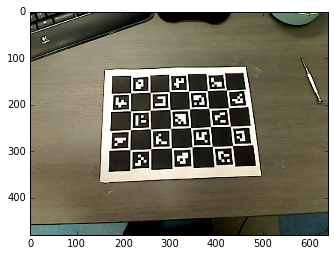

In [88]:
ind = 0
img = read_image(images[ind])
plt.imshow(img)
images[ind]

In [89]:
a,b,c = aruco.detectMarkers(img, calib_board.dictionary)

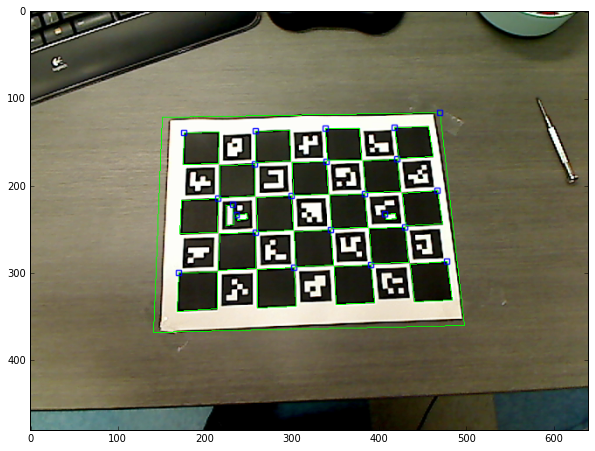

In [90]:
plt.figure(figsize=(10,15))
plt.imshow(aruco.drawDetectedMarkers(img, c))

In [92]:
len(cam_cal_data['rotationVector']), cam_cal_data['rotationVector'][ind].shape

(49, (3, 1))

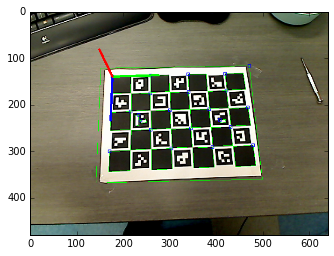

In [93]:
plt.imshow(aruco.drawAxis(img.copy(), cam_cal_data['cameraMatrix'], cam_cal_data['distCoeffs'],
          cam_cal_data['rotationVector'][ind], cam_cal_data['translationVector'][ind], 0.09))

In [251]:
cam_cal_data

{'cameraMatrix': array([[524.10342668,   0.        , 323.49844061],
        [  0.        , 522.73949737, 250.24476893],
        [  0.        ,   0.        ,   1.        ]]),
 'distCoeffs': array([[ 0.06786745, -0.25414535,  0.0063491 ,  0.00304427, -0.00894483]]),
 'reprojectionError': 0.045216385752889554,
 'rms': 0.3388060095575076,
 'rotationVector': [array([[ 2.09045067],
         [ 2.00181837],
         [-0.25337236]]), array([[ 2.08662181],
         [ 2.01558804],
         [-0.26381178]]), array([[ 2.06676128],
         [ 2.03937309],
         [-0.28094216]]), array([[ 2.02978437],
         [ 2.07445633],
         [-0.3224416 ]]), array([[ 1.80841649],
         [ 2.01284693],
         [-0.59832383]]), array([[ 2.02591472],
         [ 2.10051554],
         [-0.37530815]]), array([[ 1.81300402],
         [ 2.00577431],
         [-0.5926417 ]]), array([[ 2.00520231],
         [ 2.15470455],
         [-0.4708113 ]]), array([[ 1.98919124],
         [ 2.14379726],
         [-0.48865794

## Pose Estimation

In [175]:
cam_cal_data.keys()

['rms',
 'rotationVector',
 'cameraMatrix',
 'translationVector',
 'distCoeffs',
 'reprojectionError']

In [176]:
camera_matrix = cam_cal_data['cameraMatrix']
dist_coeffs = cam_cal_data['distCoeffs']

#### Estimate Pose Board

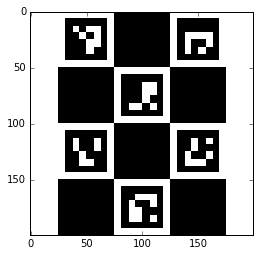

In [177]:
showMarker(board1.draw((200,200)))

In [396]:
frame = im_cat.copy()
corners, ids, rejectedImgPoints = aruco.detectMarkers(frame, board1.dictionary)
retval,rvec,tvec = aruco.estimatePoseBoard( corners, ids, board1, camera_matrix, dist_coeffs, None, None, False )
# frame = aruco.drawAxis( frame, camera_matrix, dist_coeffs, rvec, tvec, mrklen )
# frame = aruco.drawDetectedMarkers( frame, corners, ids )


In [399]:
np.isn

True

In [ ]:
frame = aruco.drawDetectedCornersCharuco

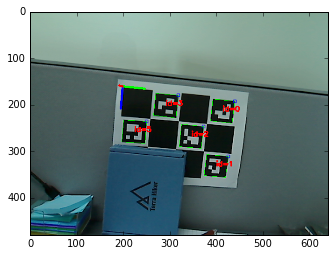

In [250]:
plt.imshow(frame)

In [ ]:
board1.

#### Draw coordinate frame of every marker

In [352]:
aruco.estimatePoseSingleMarkers?

In [385]:
mrklen = 0.04865 
frame = im_full.copy()

corners, ids, rejectedImgPoints = aruco.detectMarkers(frame, board1.dictionary)

retval,rvec,tvec = aruco.estimatePoseSingleMarkers( corners, mrklen, camera_matrix, dist_coeffs, None, None, False )

frame = aruco.drawDetectedMarkers( frame, corners, ids )

for ind in range(min(len(tvec), len(rvec))):
    frame = aruco.drawAxis( frame, camera_matrix, dist_coeffs, rvec[ind], tvec[ind], mrklen )


In [389]:
length_of_axis = 0.1
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

for i in range(len(tvec)):
    imaxis = aruco.drawAxis(imaxis, camera_matrix, dist_coeffs, rvec[i], tvec[i], length_of_axis)

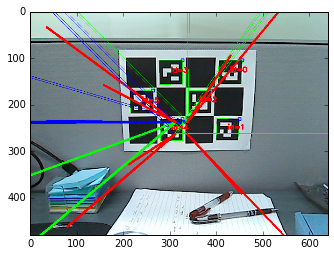

In [391]:
plt.imshow(imaxis)

#### estimatePoseCharucoBoard 

In [279]:
frame = im_full.copy()
corners, ids, rejectedImgPoints = aruco.detectMarkers(frame, board1.dictionary, camera_matrix, dist_coeffs)
corners, ids, rjcorners, recids = aruco.refineDetectedMarkers(frame, board1, corners, ids, rejectedImgPoints,
                                                             camera_matrix, dist_coeffs)

ret, ch_corners, ch_ids = aruco.interpolateCornersCharuco(corners, ids, frame, board1)

retval,rvec,tvec = aruco.estimatePoseCharucoBoard(ch_corners, ch_ids, board1, camera_matrix, dist_coeffs, None,None, False)


frame = aruco.drawAxis( frame, camera_matrix, dist_coeffs, rvec, tvec, mrklen )
frame = aruco.drawDetectedMarkers( frame, corners, ids )
frame = aruco.drawDetectedCornersCharuco(frame, ch_corners, ch_ids)

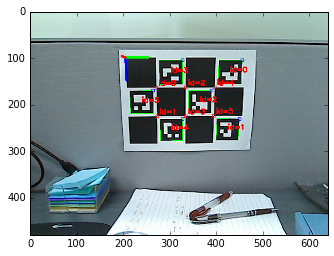

In [280]:
plt.imshow(frame)

In [240]:
aruco.interpolateCornersCharuco?

In [248]:
aruco.detectMarkers?

In [236]:
len(corners)

5

In [257]:
np.array([1,2,3]) != None

array([ True,  True,  True])

In [265]:
type(rvec)==np.ndarray

True

In [259]:
all(None)

TypeError: 'NoneType' object is not iterable

In [253]:
tvec

array([[-0.12673641],
       [-0.09028369],
       [ 0.52689309]])

In [253]:
help(aruco.CharucoBoard_create)

Help on built-in function CharucoBoard_create:

CharucoBoard_create(...)
    CharucoBoard_create(squaresX, squaresY, squareLength, markerLength, dictionary) -> retval
    .   * @brief Create a CharucoBoard object
    .        *
    .        * @param squaresX number of chessboard squares in X direction
    .        * @param squaresY number of chessboard squares in Y direction
    .        * @param squareLength chessboard square side length (normally in meters)
    .        * @param markerLength marker side length (same unit than squareLength)
    .        * @param dictionary dictionary of markers indicating the type of markers.
    .        * The first markers in the dictionary are used to fill the white chessboard squares.
    .        * @return the output CharucoBoard object
    .        *
    .        * This functions creates a CharucoBoard object given the number of squares in each direction
    .        * and the size of the markers and chessboard squares.



In [88]:
help(aruco.estimatePoseCharucoBoard)

Help on built-in function estimatePoseCharucoBoard:

estimatePoseCharucoBoard(...)
    estimatePoseCharucoBoard(charucoCorners, charucoIds, board, cameraMatrix, distCoeffs[, rvec[, tvec[, useExtrinsicGuess]]]) -> retval, rvec, tvec
    .   * @brief Pose estimation for a ChArUco board given some of their corners
    .   * @param charucoCorners vector of detected charuco corners
    .   * @param charucoIds list of identifiers for each corner in charucoCorners
    .   * @param board layout of ChArUco board.
    .   * @param cameraMatrix input 3x3 floating-point camera matrix
    .   * \f$A = \vecthreethree{f_x}{0}{c_x}{0}{f_y}{c_y}{0}{0}{1}\f$
    .   * @param distCoeffs vector of distortion coefficients
    .   * \f$(k_1, k_2, p_1, p_2[, k_3[, k_4, k_5, k_6],[s_1, s_2, s_3, s_4]])\f$ of 4, 5, 8 or 12 elements
    .   * @param rvec Output vector (e.g. cv::Mat) corresponding to the rotation vector of the board
    .   * (see cv::Rodrigues).
    .   * @param tvec Output vector (e.g. cv::Mat

In [312]:
pt = np.array([[0,10],[0,10],[0,10]])
pt[2]

array([ 0, 10])

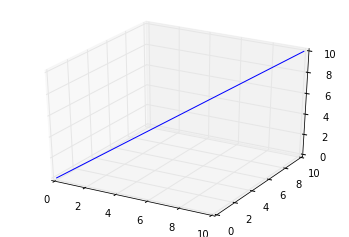

In [311]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pt[0],pt[1],pt[2], MarkerSize=3)

In [313]:
board_corners = [np.array([[0.09,0.01,0.0],[0.09,0.09,0.],[0.01,0.09,0.],[0.01,0.01,0.]],dtype=np.float32),
 np.array([[0.09,0.10,0.01],[0.09,0.10,0.09],[0.01,0.10,0.09],[0.01,0.10,0.01]],dtype=np.float32),
 np.array([[0.09,0.0,0.09],[0.09,0.0,0.01],[0.01,0.0,0.01],[0.01,0.0,0.09]],dtype=np.float32),
 np.array([[0.09,0.09,0.10],[0.09,0.01,0.10],[0.01,0.01,0.10],[0.01,0.09,0.10]],dtype=np.float32)]
board_ids = np.array( [[0],[10],[14],[12]], dtype=np.int32)
board = aruco.Board_create( board_corners,
 aruco.getPredefinedDictionary(aruco.DICT_6X6_250),
 board_ids )

In [319]:
board_corners

[array([[0.09, 0.01, 0.  ],
        [0.09, 0.09, 0.  ],
        [0.01, 0.09, 0.  ],
        [0.01, 0.01, 0.  ]], dtype=float32), array([[0.09, 0.1 , 0.01],
        [0.09, 0.1 , 0.09],
        [0.01, 0.1 , 0.09],
        [0.01, 0.1 , 0.01]], dtype=float32), array([[0.09, 0.  , 0.09],
        [0.09, 0.  , 0.01],
        [0.01, 0.  , 0.01],
        [0.01, 0.  , 0.09]], dtype=float32), array([[0.09, 0.09, 0.1 ],
        [0.09, 0.01, 0.1 ],
        [0.01, 0.01, 0.1 ],
        [0.01, 0.09, 0.1 ]], dtype=float32)]

In [323]:
board_corners[0][:,0]

array([0.09, 0.09, 0.01, 0.01], dtype=float32)

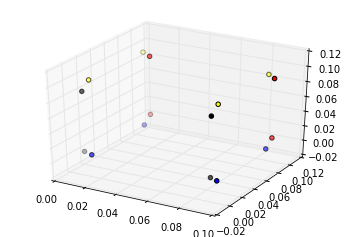

In [338]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
col = ['blue', 'red', 'black', 'yellow']
for ind in range(0,4):
    x = np.array(board_corners[ind][:,0]).flatten()
    y = np.array(board_corners[ind][:,1]).flatten()
    z = np.array(board_corners[ind][:,2]).flatten()
    ax.scatter(x,y,z, c = col[ind])

### 3D board

In [382]:
mlen = 0.11367
x1_off = -0.18
y1_off = -0.158
z1_off = -0.024

x2_off = 0.074
y2_off = -0.029
z2_off = 0.
board_corners = [
    np.array([[x1_off, y1_off, z1_off], #1
              [mlen+x1_off, y1_off, z1_off],
              [mlen+x1_off, y1_off, -mlen+z1_off],
              [x1_off, y1_off, -mlen+z1_off]], dtype=np.float32),
    
    np.array([[x2_off, y2_off, z2_off],
              [mlen+x2_off, y2_off, z2_off],
              [mlen+x2_off, -mlen+y2_off, z2_off],
              [x2_off, -mlen+y2_off, z2_off]], dtype=np.float32)]
              
board_ids = np.array( [[11],[12]], dtype=np.int32)
board = aruco.Board_create(board_corners, aruco_dict, board_ids)

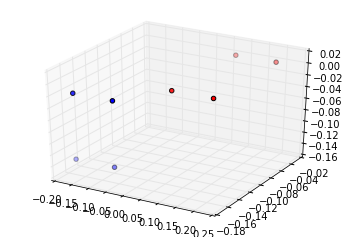

In [383]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
col = ['blue', 'red', 'black', 'yellow']
for ind in range(0,2):
    x = np.array(board_corners[ind][:,0]).flatten()
    y = np.array(board_corners[ind][:,1]).flatten()
    z = np.array(board_corners[ind][:,2]).flatten()
    ax.scatter(x,y,z, c = col[ind])

In [351]:
aruco.estimatePoseSingleMarkers?

In [350]:
aruco.drawDetectedMarkers?